# CAR PRICE PREDICTION ANALYSIS
The project develops a machine learning pipeline to estimate the selling prices of used cars.
Given a dirty dataset with confusing outliers, my approach was the  application of Random Forest models on reliable data.

# Import, data analysis and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

## Performance analysis function

In [3]:
def regression_performance_report(model, X_test, y_test, show_plot=False):
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    if show_plot:
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Model Performance Diagnostics', fontsize=16)

        # Plot 1: Actual vs. Predicted
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, color='royalblue', ax=ax[0])
        ideal_line = [y_test.min(), y_test.max()]
        ax[0].plot(ideal_line, ideal_line, 'r--', lw=2, label='Perfect Prediction')
        ax[0].set_title('Actual vs. Predicted Price')
        ax[0].set_xlabel('Actual Price (€)')
        ax[0].set_ylabel('Predicted Price (€)')
        ax[0].legend()

        # Plot 2: Distribution of Errors
        residuals = y_test - y_pred
        sns.histplot(residuals, kde=True, color='rebeccapurple', ax=ax[1], kde_kws={'bw_adjust': 2})
        
        # Focus on 98% of the data to remove the "squashing" effect
        lower = np.percentile(residuals, 1)
        upper = np.percentile(residuals, 99)
        ax[1].set_xlim(lower, upper) 
        
        ax[1].set_title('Distribution of Prediction Errors (Zoomed)')
        ax[1].set_xlabel('Error (€)')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return pd.Series({'MAE': mae, 'RMSE': rmse, 'R2 Score': r2, 'MAPE (%)': mape})

## Data cleaning

First I had to understand the structure and quality of the dataset.

In [6]:
df = pd.read_csv('auto_price.csv')
print("Shape:", df.shape)
print(df.info())

Shape: (178248, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178248 entries, 0 to 178247
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                178248 non-null  int64  
 1   MatriculationMonth   178248 non-null  object 
 2   MatriculationYear    178248 non-null  int64  
 3   km                   146756 non-null  float64
 4   cv                   166933 non-null  float64
 5   FuelType             177485 non-null  object 
 6   gearboxType          177121 non-null  object 
 7   Consume              131811 non-null  object 
 8   city                 178172 non-null  object 
 9   province             178172 non-null  object 
 10  Brand                178087 non-null  object 
 11  Model                178087 non-null  object 
 12  Preparation          178087 non-null  object 
 13  Engine               169898 non-null  float64
 14  Seats                162098 non-null  float64
 1

In [7]:
#Clean 'Consume' (convert "5,4 l/100km" -> 5.4)
# Extract the number and fix the decimal separator
df['Consume'] = df['Consume'].astype(str).str.extract(r'(\d+[\.,]?\d*)')[0]
df['Consume'] = df['Consume'].str.replace(',', '.').astype(float)

# Clean 'NumberDoors'
# 'coerce' turns invalid errors into NaN (empty).
df['NumberDoors'] = pd.to_numeric(df['NumberDoors'], errors='coerce')

# Drop Duplicates
print(f"The duplicates in the dataset were {df.duplicated().sum()}")
df_clean = df.drop_duplicates()

print(f"Rows remaining: {len(df_clean)}")

The duplicates in the dataset were 46417
Rows remaining: 131831


## Analysis and cleaning of the quantitative data

To prevent the model to learn from anomalies and errrors on data, I checked the statistics of the numerical data(floats&integers) to remove the outliers which were not possible according to real-world data.

In [10]:
# Set option to display floats with 2 decimal places (no scientific notation)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# describe table for numerical data
stats = df_clean[['price', 'MatriculationYear', 'km', 'cv', 'Engine', 'Seats', 'ConsumeFuel', 'Emissions']].describe()

print(stats)

           price  MatriculationYear            km        cv    Engine  \
count  131831.00          131831.00     110479.00 123683.00 125913.00   
mean    20089.65            2012.94      91385.86     98.92   1711.08   
std     27103.56               7.04    6461003.34     91.87    778.51   
min       239.00            1900.00          1.00      0.00      1.00   
25%      8990.00            2011.00      16065.50     70.00   1368.00   
50%     15690.00            2015.00      58700.00     85.00   1598.00   
75%     24200.00            2017.00     112334.00    110.00   1995.00   
max   3500000.00            2018.00 2147483647.00  13950.00  96400.00   

          Seats  ConsumeFuel  Emissions  
count 120274.00     91482.00   90794.00  
mean       5.71         5.36     130.82  
std      331.59        19.98      38.87  
min        1.00         0.00       0.00  
25%        5.00         4.10     108.00  
50%        5.00         4.90     119.00  
75%        5.00         5.90     144.00  
max   

In [11]:
#Defining realistic ranges
df_filtered = df_clean[
    (df_clean['km'].between(1, 1000000)) &            # Keep cars between 1km and 1m km
    (df_clean['Seats'].between(2, 9)) &               # 2 to 9 seats
    (df_clean['cv'].between(40, 1000)) &              # 40cv to 1000cv
    (df_clean['Engine'] < 8000) &                     # 0cc(electric cars) to 8000cc engine
    (df_clean['ConsumeFuel'] < 30) &                  # Max 30L/100km
    (df_clean['ConsumeFuelNotUrban'] < 30) &          # Max 30L/100km
    (df_clean['Emissions'] < 800) &                   # Max 800g of CO2
    (df_clean['price'].between(500,1000000)) &         # Remove < 500$ cars and >1m$ 
    (df_clean['MatriculationYear'] > 1950)]          #there was a car with mat.year=1900(impossible)
#Add 'CarAge': calculate Age and drop the 'MatriculationYear' column
df_filtered = df_filtered.copy()
df_filtered['CarAge'] = 2026 - df_filtered['MatriculationYear']
df_filtered = df_filtered.drop(columns=['MatriculationYear'])

### Cleaned quantitative data

In [13]:
#Set option to display floats with 2 decimal places (no scientific notation)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# describe table
stats = df_filtered[['price', 'CarAge', 'km', 'cv', 'Engine', 'Seats', 'ConsumeFuel', 'Emissions']].describe()

print(stats)

          price   CarAge        km       cv   Engine    Seats  ConsumeFuel  \
count  69012.00 69012.00  69012.00 69012.00 69012.00 69012.00     69012.00   
mean   19521.98    12.51  67813.66   101.14  1786.26     4.80         5.25   
std    19892.83     3.85  63058.12    52.41   606.03     0.84         1.69   
min      500.00     8.00      1.00    40.00     1.00     2.00         0.00   
25%     8900.00     9.00  15246.75    70.00  1461.00     5.00         4.10   
50%    15500.00    11.00  53769.50    88.00  1598.00     5.00         4.90   
75%    23900.00    15.00 107783.75   110.00  1995.00     5.00         5.90   
max   880000.00    36.00 589000.00   559.00  7011.00     9.00        25.00   

       Emissions  
count   69012.00  
mean      133.46  
std        40.51  
min         0.00  
25%       109.00  
50%       122.00  
75%       148.00  
max       500.00  


Now the numerical data are in realistic ranges and ready  to be anaalysed

### Removal of useless data

I decided to remove some features which were not useful for the analysis, intuitively.

In [17]:
#Drop useless columns:
df_final = df_filtered.drop(columns=['MatriculationMonth','Preparation', 'city','Interior','Color','Consume'], errors='ignore').copy()

## OneHot encoding and Label encoding for the qualitative variables:

In [19]:
#Label Encoding (High Cardinality)
# Used for ['Brand', 'Model', 'province'] because they have several values.
# One-Hot encoding here would create too many columns.
le = LabelEncoder()
label_cols = ['Brand', 'Model', 'province']

for col in label_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna('Unknown')
        df_final[col] = le.fit_transform(df_final[col].astype(str))

# One-Hot Encoding (Low Cardinality)
# This creates separate columns (True/False), which helps the model distinguish categories better.
one_hot_cols = [
    'FuelType', 'gearboxType', 'EmissionClass', 'Airbag', 'AirConditioning', 'Metallizzato'
]

df_final = pd.get_dummies(df_final, columns=one_hot_cols, drop_first=True)

# 4. Final Output
print("Encoding Complete.")
print(f"Final Shape: {df_final.shape}")
print("Columns ready:", df_final.columns.tolist())

Encoding Complete.
Final Shape: (69012, 30)
Columns ready: ['price', 'km', 'cv', 'province', 'Brand', 'Model', 'Engine', 'Seats', 'ConsumeFuel', 'ConsumeFuelNotUrban', 'Emissions', 'NumberDoors', 'CarAge', 'FuelType_Benzina', 'FuelType_Diesel', 'FuelType_GPL', 'FuelType_Ibrida (benzina/elettrica)', 'FuelType_Ibrida (diesel/elettrica)', 'FuelType_Idrogeno', 'gearboxType_Cambio manuale', 'EmissionClass_Euro 2', 'EmissionClass_Euro 3', 'EmissionClass_Euro 4', 'EmissionClass_Euro 5', 'EmissionClass_Euro 6', 'Airbag_Airbag anteriori e laterali', 'Airbag_Airbag anteriori e laterali e di altro tipo', 'Airbag_Airbag conducente', 'AirConditioning_Climatizzatore manuale', 'AirConditioning_Senza climatizzatore']


Summary of the Datasets:
df: The raw and unfiltered dataset\
df_clean: make data seradable, fixing Consume and NumberDoors, removal of the duplicates\
df_filtered: applied real-world constraints to data, removing the outliers and creation of 'Car Age' from 'Matriculation Year'\
df_final: dropped useless columns(like Color or Interior), converted text data into numbers through Label Encoding and OneHot encoding to apply the ML model.\

# Analysis of the variables

Before building the model it was better to visualize and understand the features which have the  strongest statistical relationship with price; I will use those plots later to select the variables for the model, to use only the relevant ones.

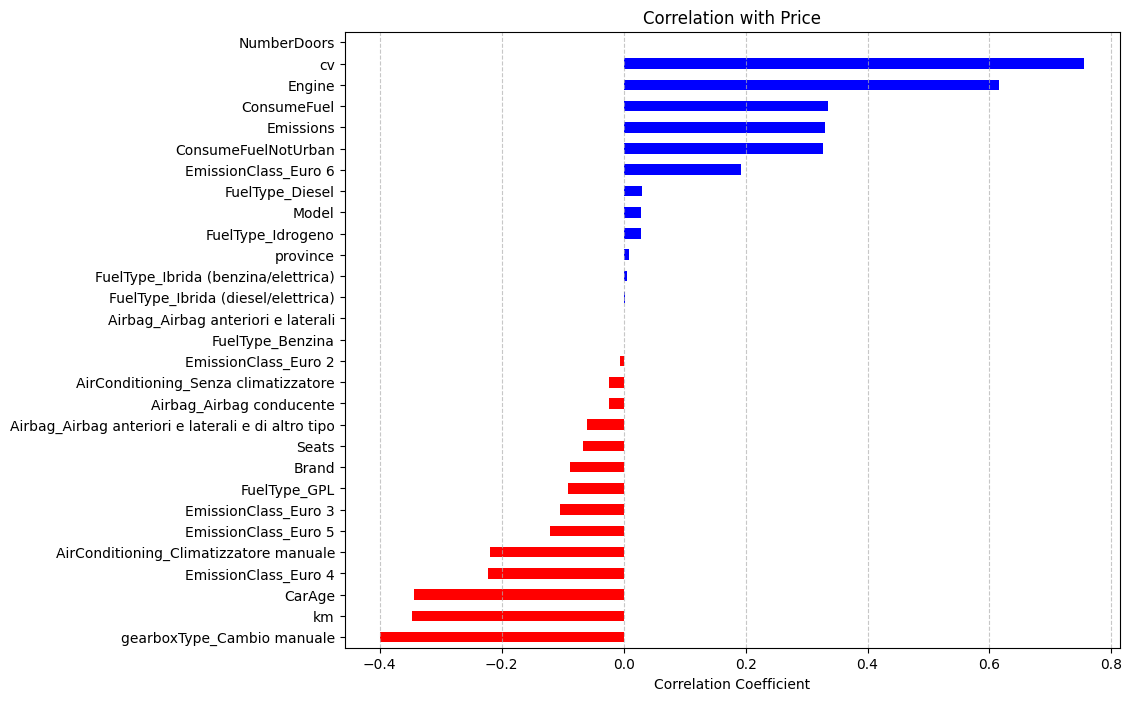

In [23]:
# Calculate correlations with Price
corr_with_price = df_final.corr(numeric_only=True)['price'].sort_values(ascending=True)
corr_with_price = corr_with_price.drop('price')
# Plot a Bar Chart
plt.figure(figsize=(10, 8))
# Use a color palette that maps positive to blue and negative to red
colors = ['blue' if x > 0 else 'red' for x in corr_with_price.values]
corr_with_price.plot(kind='barh', color=colors)

plt.title('Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Quick visualization of the top 4 price drivers

The following plots helped to see the non-linear relationships between the most relevant and highly cardinal variables with respect to price.

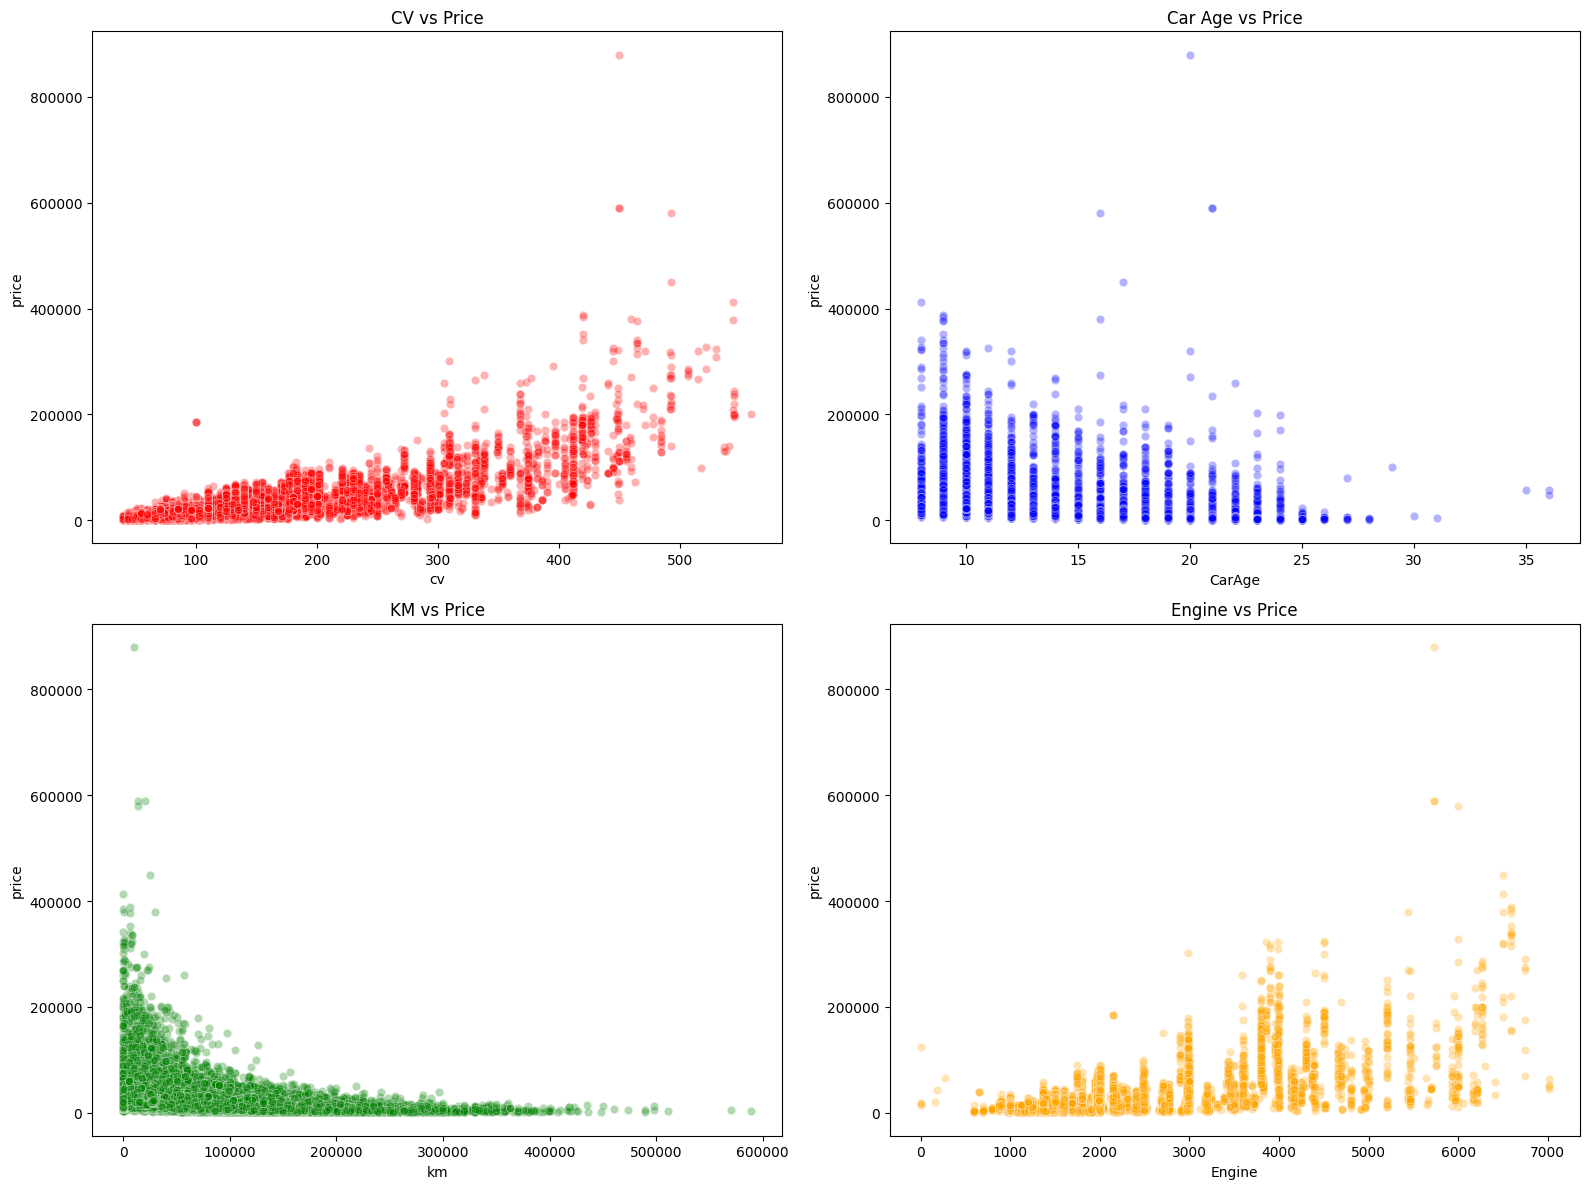

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Power (CV)
sns.scatterplot(x='cv', y='price', data=df_final, alpha=0.3, color='red', ax=axes[0, 0])
axes[0, 0].set_title('CV vs Price')

# 2. Age
sns.scatterplot(x='CarAge', y='price', data=df_final, alpha=0.3, color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Car Age vs Price')

# 3. Usage (KM)
sns.scatterplot(x='km', y='price', data=df_final, alpha=0.3, color='green', ax=axes[1, 0])
axes[1, 0].set_title('KM vs Price')

# 4. Engine Size
sns.scatterplot(x='Engine', y='price', data=df_final, alpha=0.3, color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Engine vs Price')
#To remove the scientific notation
for ax in axes.flat:
    ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Random Forest with all the features of df_final(30 variables)

In [28]:
df_final

price        km     cv  province  Brand  Model  Engine  Seats  \
0       15500  82914.00  85.00        54      6    477 1995.00   5.00   
1        3900 161038.00  75.00        54     65    260 1595.00   5.00   
2       15900 114830.00  80.00        54     43    145 1461.00   5.00   
3       54900  61700.00 183.00        60      6    580 2993.00   5.00   
4       45900  25790.00 190.00        60      6    580 2993.00   5.00   
...       ...       ...    ...       ...    ...    ...     ...    ...   
143981  22950  28000.00 110.00        13      6    478 1995.00   5.00   
143982  23950  27000.00 110.00        13      6    478 1995.00   5.00   
143983  23500  28000.00  85.00        13      6    478 1496.00   5.00   
143984  20950  27000.00  85.00        13      6    478 1496.00   5.00   
143985  23950  29000.00 110.00        13      6    478 1995.00   5.00   

        ConsumeFuel  ConsumeFuelNotUrban  ...  EmissionClass_Euro 2  \
0              4.10                 3.60  ...                 False   
1              7.20                 5.60  ...                 False   
2              3.80                 3.30  ...                 False   
3              5.90                 5.50  ...                 False   
4              6.20                 5.70  ...                 False   
...             ...                  ...  ...                   ...   
143981         4.10                 3.70  ...                 False   
143982         4.10                 3.70  ...                 False   
143983         3.80                 3.40  ...                 False   
143984         3.80                 3.40  ...                 False   
143985         4.10                 3.70  ...                 False   

        EmissionClass_Euro 3  EmissionClass_Euro 4  EmissionClass_Euro 5  \
0                      False                 False                 False   
1                      False                 False                 False   
2                      False                 False                 False   
3                      False                 False                 False   
4                      False                 False                 False   
...                      ...                   ...                   ...   
143981                 False                 False                 False   
143982                 False                 False                 False   
143983                 False                 False                 False   
143984                 False                 False                 False   
143985                 False                 False                 False   

        EmissionClass_Euro 6  Airbag_Airbag anteriori e laterali  \
0                      False                               False   
1                      False                               False   
2                      False                               False   
3                      False                               False   
4                      False                               False   
...                      ...                                 ...   
143981                  True                               False   
143982                  True                               False   
143983                  True                               False   
143984                  True                               False   
143985                  True                               False   

        Airbag_Airbag anteriori e laterali e di altro tipo  \
0                                                   False    
1                                                   False    
2                                                   False    
3                                                   False    
4                                                   False    
...                                                   ...    
143981                                               True    
143982                                              

## MODEL TRAINING & EVALUATION

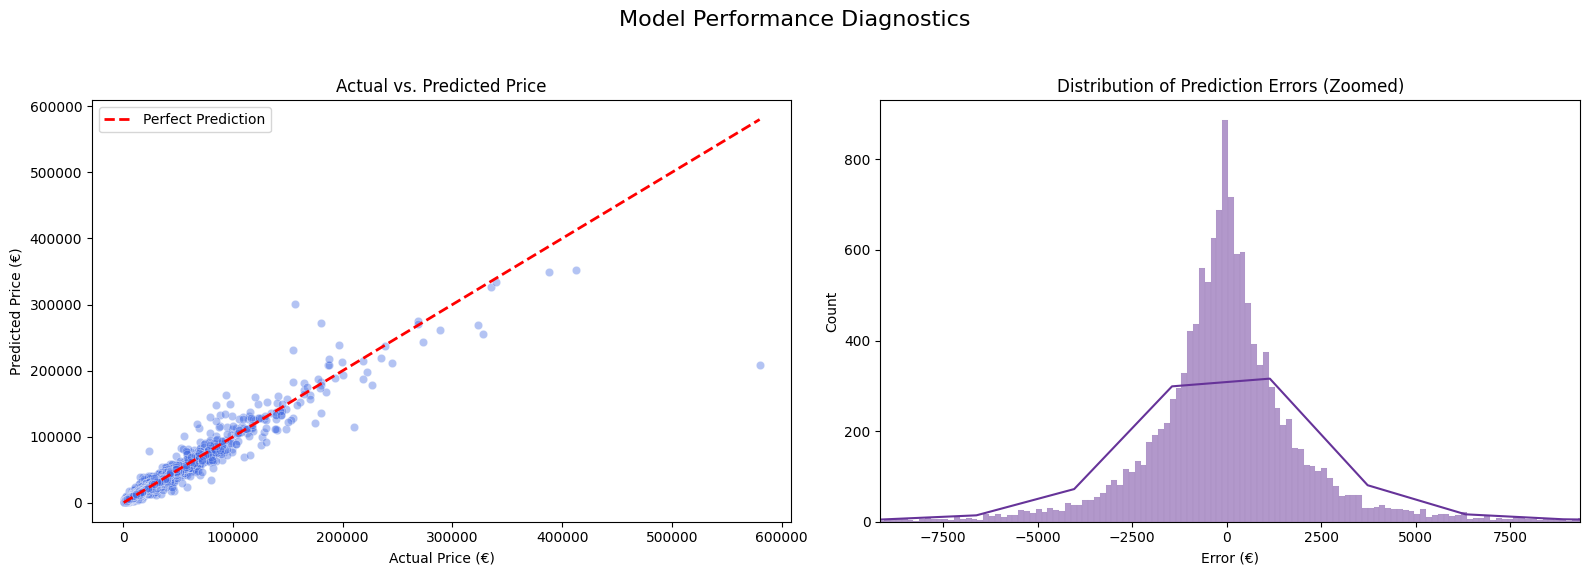

  Baseline Model Scorecard 
MAE        1776.94
RMSE       5147.33
R2 Score      0.93
MAPE (%)     11.05
dtype: float64


In [30]:
#Prepare Data
# remove the target 'price' to create the Feature Matrix (X) and Target Vector (y)
X = df_final.drop(columns=['price'])
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
# Training a Random Forest with 100 trees (using all CPU cores, n_jobs=-1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict & Score
predictions = rf_model.predict(X_test)
baseline_stats = regression_performance_report(rf_model, X_test, y_test, show_plot=True)
print("  Baseline Model Scorecard ")
print(baseline_stats)

In [31]:
# Check Training Score: Did the model learn the patterns? 
print(f"Train Score: {rf_model.score(X_train, y_train):.4f}")

# Check Test Score: Real-world accuracy on new dataset
# If Train is High (0.99) but Test is Low (0.70) = Overfitting.
# If both are High (0.99 and 0.96) = Great Model.
print(f"Test Score:  {rf_model.score(X_test, y_test):.4f}")
print('Train score: how the model has learned from data')
print('Test score: how much variance can capture the model with unseen data')

Train Score: 0.9911
Test Score:  0.9343
Train score: how the model has learned from data
Test score: how much variance can capture the model with unseen data


Good generalization of the results, the model learned the logics behind the car prices, leading to a good price estimation pattern./
However, the model uses 30 variables, which introduce unnecessary complexity. I have to perform an optimization of the  parameters.

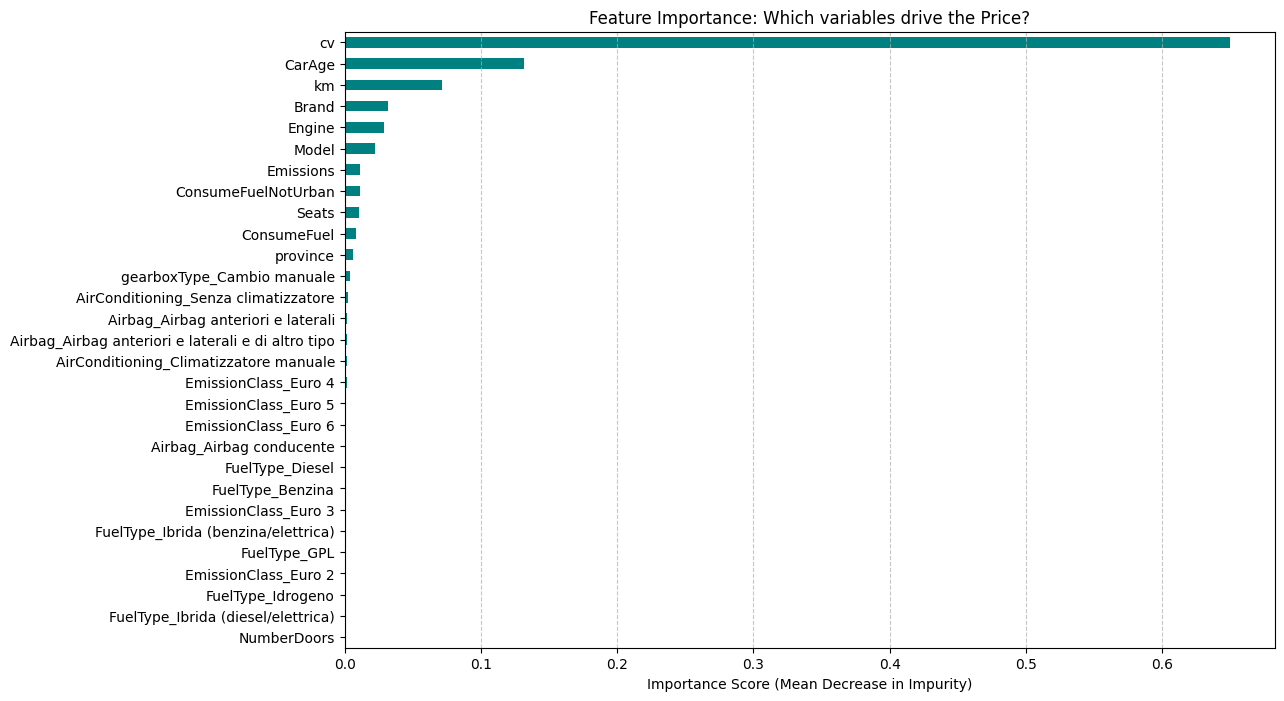

In [33]:
# Feature importance - Mean Decrease in Impurity (MDI)
# Extract importances from the trained Random Forest
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

#Sort them
sorted_importances = importances.sort_values(ascending=False)

#  Visualize the results
plt.figure(figsize=(12, 8))
sorted_importances.plot(kind='barh', color='teal')
plt.title('Feature Importance: Which variables drive the Price?')

#Mean Decrease in Impurity
plt.xlabel('Importance Score (Mean Decrease in Impurity)') 

plt.gca().invert_yaxis() # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

To solve overfitting issues, I am moving toward a more accurate, less complex model that prioritizes high-signal features identified through Mean Decrease in Impurity (MDI).\
This ranking system allows me to quantify exactly how much each feature reduces the variance of the car prices across all trees in the forest.\
By discarding the insignificant features and focusing on high-impact variables, I am reducing the risk of the model 'memorizing' irrelevant data points.\
I am removing the statistical noise that leads to overfitting.\
This ensures the model focuses strictly on the true drivers of market value.\
Ultimately, this optimization improves the model's ability to generalize, ensuring that the logic learned during training remains highly accurate when applied to new cars in the real-world market.

# Random forest with the 7 most influential features

The 7 features were selected using the previous plot, considering the MDI score\
The steps performed are:\
1.Selection of the variables\
2.Split into train and test the dataset\
3.K-cross-validation of the model\
4.Train the model on the training set\
5.Evaluation of the accuracy

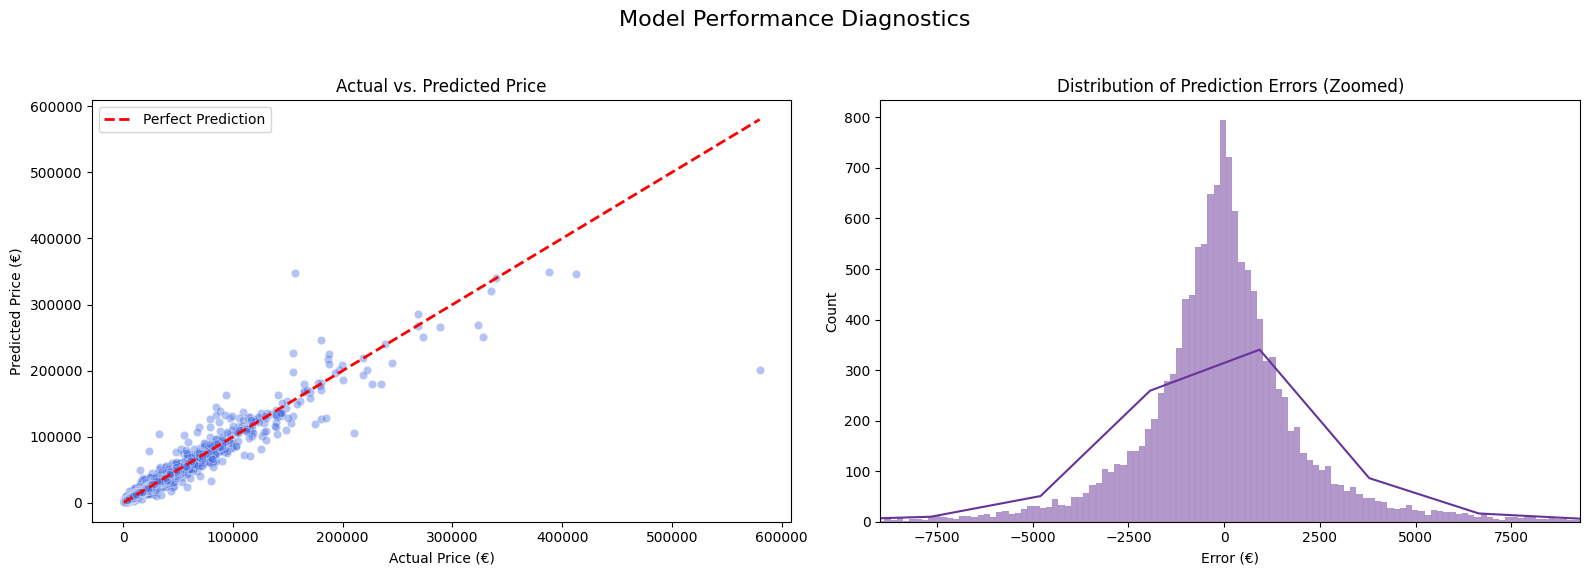

7 Vars 
Mean CV R2: 0.9292 Std Dev: 0.0185
MAE        1840.56
RMSE       5359.52
R2 Score      0.93
MAPE (%)     11.44
dtype: float64


In [37]:
# Feature Selection
top_7_features = ['cv', 'CarAge', 'km', 'Brand', 'Model', 'Engine', 'Emissions']
X7 = df_final[top_7_features]
y = df_final['price']

# Split
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y, test_size=0.2, random_state=42)

# Training & Cross-Validation
rf_7 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Stability Check: K-Fold Cross Validation
cv_scores_7 = cross_val_score(rf_7, X_train7, y_train7, cv=5, scoring='r2')

rf_7.fit(X_train7, y_train7)

# Evaluation
stats_7 = regression_performance_report(rf_7, X_test7, y_test7, show_plot=True)
print("7 Vars ")
print(f"Mean CV R2: {cv_scores_7.mean():.4f} Std Dev: {cv_scores_7.std():.4f}")
print(stats_7)

To refine the model, I reduced the complexity from 30 variables to the 7 most impactful features—['cv', 'CarAge', 'km', 'Brand', 'Model', 'Engine', 'Emissions'] based on their MDI (Mean Decrease in Impurity) ranking.\
By isolating these predictors, I stripped away the statistical noise responsible for overfitting.\
I then implemented 5-fold cross-validation to ensure the model's stability, which returned a consistent Mean R2.\
The model statistics prove that I maintained high predictive power while creating a much leaner, more generalized tool that focuses strictly on the primary economic drivers of car value.

# Random Forest with only the 5 most influential features

I selected the  ['cv', 'CarAge', 'km', 'Brand', 'Engine'] to avoid high cardinality and overfitting,  chosen following the correlation chart above.

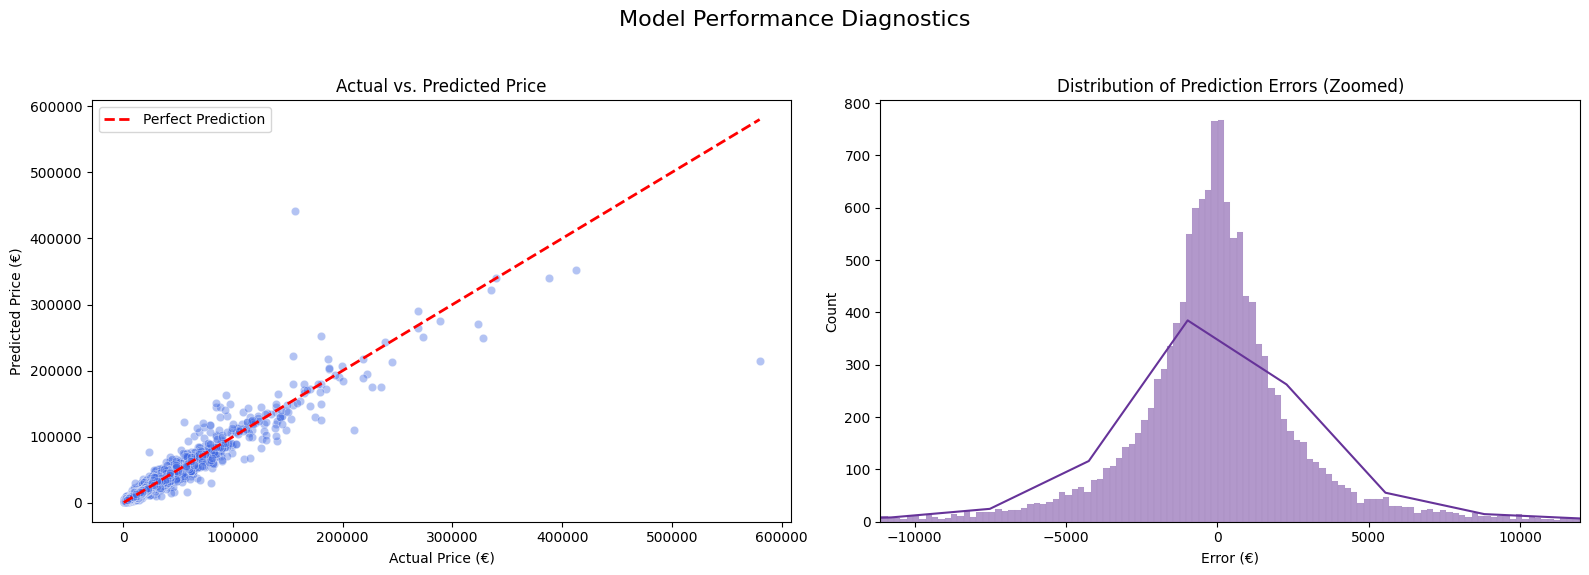

  5 Vars
Mean CV R2: 0.9121 Std Dev: 0.0174
MAE        2333.92
RMSE       5997.15
R2 Score      0.91
MAPE (%)     14.03
dtype: float64


In [41]:
# Feature Selection
top_5_features = ['cv', 'CarAge', 'km', 'Brand', 'Engine']
X5 = df_final[top_5_features]

# Split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y, test_size=0.2, random_state=42)

# Training & Cross-Validation
rf_5 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Stability Check
cv_scores_5 = cross_val_score(rf_5, X_train5, y_train5, cv=5, scoring='r2')

rf_5.fit(X_train5, y_train5)     #use 100% of  the training dataset

# Evaluation
stats_5 = regression_performance_report(rf_5, X_test5, y_test5, show_plot=True)
print("  5 Vars")
print(f"Mean CV R2: {cv_scores_5.mean():.4f} Std Dev: {cv_scores_5.std():.4f}")
print(stats_5)

## Model comparison

In [43]:
comparison_df = pd.DataFrame({
    "Metric": ["Test R2 Score", "MAE (Euro Error)", "CV Stability (Std Dev)", "Variables"],
    "Baseline": [baseline_stats['R2 Score'], f"€{baseline_stats['MAE']:.2f}", "Not performed", 30],
    "Model 7 ": [stats_7['R2 Score'], f"€{stats_7['MAE']:.2f}", f"{cv_scores_7.std():.4f}", 7],
    "Model 5 ": [stats_5['R2 Score'], f"€{stats_5['MAE']:.2f}", f"{cv_scores_5.std():.4f}", 5]
})

print("COMPARISON")
print(comparison_df.to_string(index=False))

COMPARISON
                Metric      Baseline Model 7  Model 5 
         Test R2 Score          0.93     0.93     0.91
      MAE (Euro Error)      €1776.94 €1840.56 €2333.92
CV Stability (Std Dev) Not performed   0.0185   0.0174
             Variables            30        7        5


Based on the final comparison, I have selected Model 7 as the optimal predictor for car prices.
The model with 7 variables offered the best tradeoff between high accuracy and low complexity.\
The model with 30 features shows the lowest absolute error, but the risk of overfitting the data is high.\
The model with 7 variables instead allowed me to keep the same R2 score while reducing the feature set, with a negligible increase in the absolute mean error.\
The model  with 5 features showed a high MAE, suggesting that by removing 'Model' and 'Emissions' variables the predictor gained inaccuracy, leading to thhe conclusion that the 5-features models was an oversimplification\
I decided to keep the 7-features model valid for the Hyperparameter optimization.

# Optimization

The optimization of the hyperparameters is a fundamental step to find the best configuration for the  Random Forest to be more precise and leaner.\
I ran the optimization on the model with 7 variables.

In [47]:
# HYPERPARAMETER TUNING (Add/Remove Complexity)
#  max_depth: Controls how "deep" the trees grow (complexity)
#  n_estimators: Number of trees (stability)
#  min_samples_split: Controls overfitting (higher = simpler model)
param_grid = {
    'n_estimators': [50, 100],       # Try more trees
    'max_depth': [10, 20, 30],              # 10 = restricted (simple)
    'min_samples_split': [2, 5, 10],        # Higher numbers prevent overfitting
    'min_samples_leaf': [1, 2, 4],          # Higher numbers simplify the model
    'max_features': ['sqrt', None]  # 'sqrt'=look only to some random features,None uses all features
}

## Optimization of the parameters for the Random Forest

Best Parameters found: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
  Stability Report
Average R2 across 5 folds: 0.9307
Stability (Std Dev): 0.0199
FINAL EVALUATION ON TEST DATA


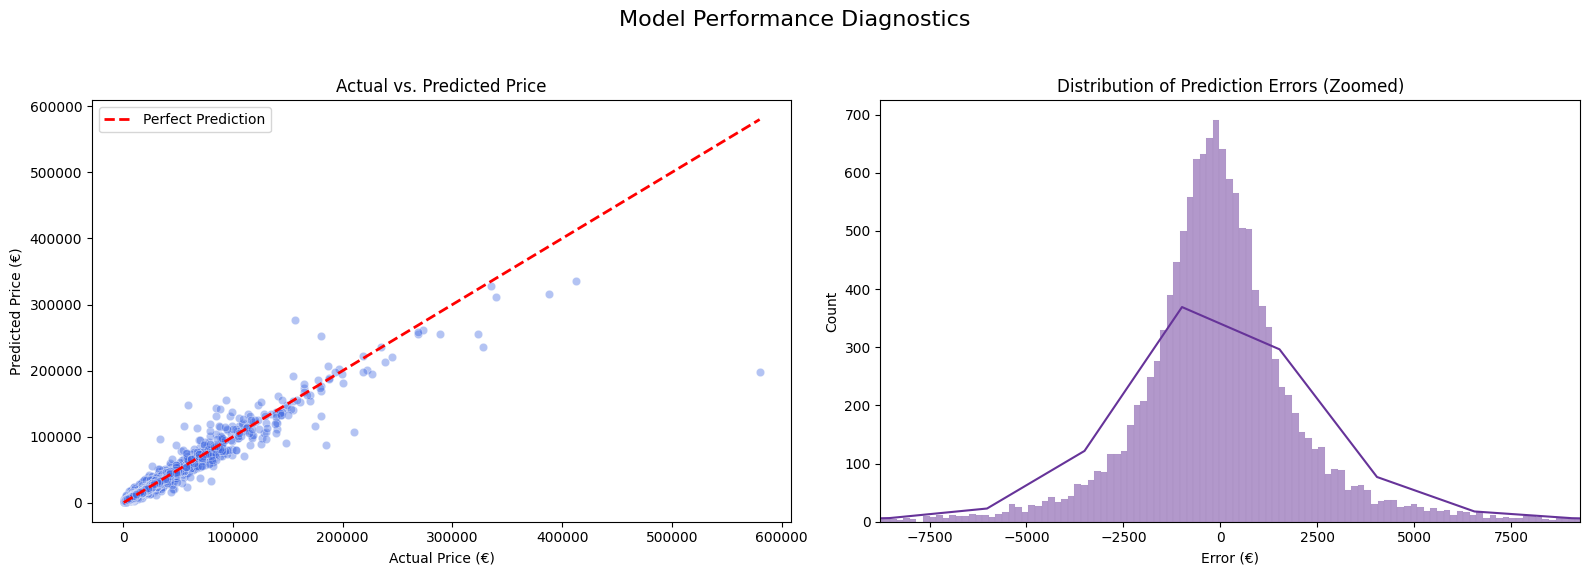

MAE        1848.22
RMSE       5266.80
R2 Score      0.93
MAPE (%)     11.43
dtype: float64


In [49]:
# Feature Selection
X_final = X7 
y_final = y

# The 80/20 Split
# Splitting the data: 80% for training the brain of the model, and 20% kept to test it later.
X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X_final, y_final, test_size=0.20, random_state=42
)

# Hyperparameter Tuning
# I'm taking a 20% slice of the training data to run a 'Search'. 
# This helps find the best settings (like tree depth) without waiting for hours.
X_tune7 = X_train7.sample(frac=0.2, random_state=42)
y_tune7 = y_train7.loc[X_tune7.index]

# Setting up the search grid to find the perfect balance between accuracy and simplicity
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10, 
    cv=3, 
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_tune7, y_tune7)
print(f"Best Parameters found: {rf_random.best_params_}")

# Stability Check (Cross-Validation)
#K-Fold Cross-Validation.
final_model_7 = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)

cv_scores_7 = cross_val_score(final_model_7, X_train7, y_train7, cv=5, scoring='r2')

print(f"  Stability Report")
print(f"Average R2 across 5 folds: {cv_scores_7.mean():.4f}")
print(f"Stability (Std Dev): {cv_scores_7.std():.4f}") 

# Final Training
# Now the model runs on the full 80% training set using the best parameters.
final_model_7.fit(X_train7, y_train7)

# Final Evaluation
# Testing the model on test set
print(f"FINAL EVALUATION ON TEST DATA")
final_results_7 = regression_performance_report(final_model_7, X_test7, y_test7, show_plot=True)

print(final_results_7)

Mean R2 vs Final R2:
Stability: model is quite stable

In [ ]:
from sklearn.model_selection import learning_curve

# Generate data for the Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    final_model_7, X_train7, y_train7, cv=5, 
    scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='s')

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

The convergence of the training and validation scores indicates a well-optimized model, managing the tradeoff betweeen bias and variance.\
The high level of the R2 stabilizes at 0.93(in the cross-validation), meaning that from 40 thousand observations and the accuracy of the model is not improved.

# Gradient Boosting

In [ ]:
# TESTING XGBOOST (GRADIENT BOOSTING)

# I'm testing XGBoost to see if it can beat the Random Forest.
#While RF builds trees in parallel, XGBoost builds them one by one, where each new tree tries to fix the residuals of the previous one.

# 1. Initialize the XGBoost Regressor
# I'm using a low learning rate (0.05) to make the learning more precise.
xgb_model = XGBRegressor(
    n_estimators=500,     # More trees, but the learning rate keeps it from overshooting
    learning_rate=0.05, 
    max_depth=6,          # XGBoost usually prefers less trees than Random Forest
    subsample=0.8,        # Using 80% of data per tree to prevent overfitting
    colsample_bytree=0.8, 
    n_jobs=-1, 
    random_state=42
)

# 2. Fit the model on the 7-variable training set
xgb_model.fit(X_train7, y_train7)

# 3. Predict and Score
xgb_preds = xgb_model.predict(X_test7)

# use the same regression report
xgb_results = regression_performance_report(xgb_model, X_test7, y_test7, show_plot=True)


print("XGBOOST PERFORMANCE REPORT")
print(xgb_results)

# 4.XGBoost vs. Optimized Random Forest
# compare the R2 score of this XGBoost againstthe optimized Random forest
rf_r2 = final_results_7['R2 Score']
xgb_r2 = xgb_results['R2 Score']

print(" " + "-"*30)
print(f"Random Forest R2: {rf_r2:.4f}")
print(f"XGBoost R2:       {xgb_r2:.4f}")
print("-"*30)

if xgb_r2 > rf_r2:
    improvement = (xgb_r2 - rf_r2) / rf_r2 * 100
    print(f"RESULT: XGBoost won by {improvement:.2f}%! It's our new best model.")
else:
    print("RESULT: Random Forest is better")

# Visualization of some decision trees

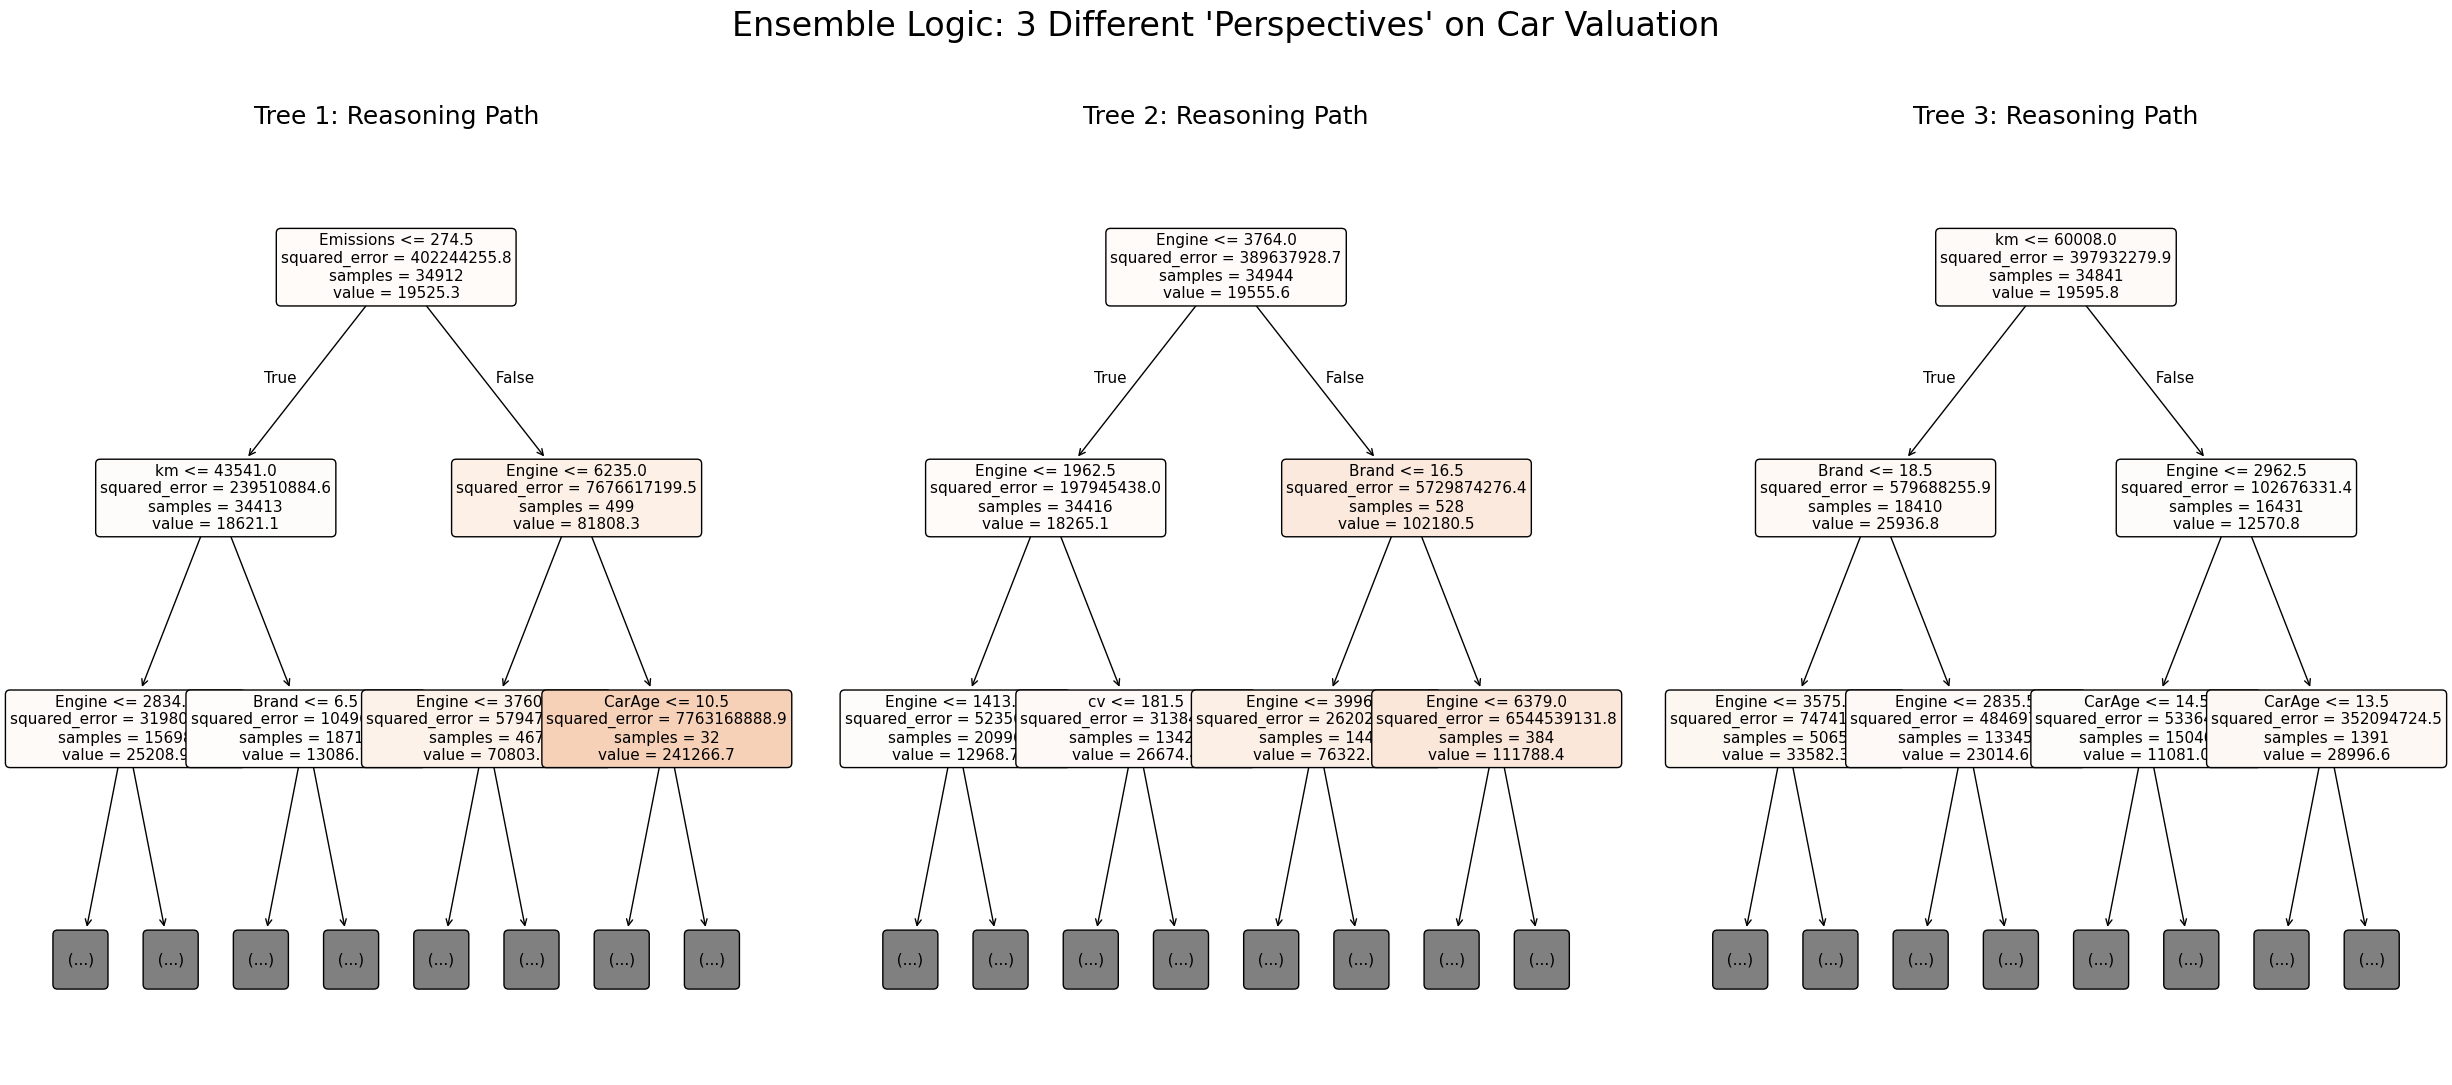

In [58]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 1. Setup the figure grid (1 row, 3 columns)
# We use a wide layout so each tree has space to breathe
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

# 2. Loop through the first 3 trees of your optimized Random Forest
for i in range(3):
    # Select the trees
    tree_to_plot = final_model_7.estimators_[i]
    
    # Plotting logic
    plot_tree(tree_to_plot, 
              feature_names=top_7_features, 
              max_depth=2,       # Keeping it at 2 for a clear "birds-eye" view of the logic
              filled=True,       # Colors indicate the predicted price level
              precision=1, 
              rounded=True, 
              fontsize=11,
              ax=axes[i])
    
    axes[i].set_title(f"Tree {i+1}: Reasoning Path", fontsize=18, pad=20)

# 3. Final visual adjustments
plt.tight_layout()
plt.suptitle("Ensemble Logic: 3 Different 'Perspectives' on Car Valuation", 
             fontsize=24, y=1.08)
plt.show()

This visualization shows the first 3 decision trees from the optimized Random Forest composed by 7 variables; 
Each tree is trained on a random subset of data and features, leading to diverse 'perspectives' on car valuation
The diversity on the focus of each tree leads to a reduction of noise and by averaging all the responses of the 100 trees the model achieves high stability and predictability power

# Price estimator

In [ ]:
print("CAR PRICE PREDICTOR")

# 1. BRAND SELECTION
user_brand = input("Insert Brand: ").strip().lower()

# Check if brand exists in our database
available_brands = df_filtered['Brand'].str.lower().unique()

if user_brand in available_brands:
    # MODEL PROPOSAL
    # Filter the dataset to find only models that belong to the chosen brand
    brand_models = df_filtered[df_filtered['Brand'].str.lower() == user_brand]['Model'].unique()
    brand_models = sorted([str(m) for m in brand_models]) # Sort alphabetically
    
    # Filter df_filtered to find only the models linked to the brand inserted
    print(f" Available models for {user_brand.upper()}:")
    print(", ".join(brand_models))
    
    user_model = input(" Model from the list above:").strip().lower()
    
    # Validation for the model
    # If the model is not in the list, just consider as if it was the most frequent model of the database
    if user_model not in [m.lower() for m in brand_models]:
        print(f"Model not recognized. Using the most common {user_brand} model instead.")
        user_model = df_filtered[df_filtered['Brand'].str.lower() == user_brand]['Model'].mode()[0].lower()
else:
    print("Brand not found. Using general market averages.")
    user_brand = df_filtered['Brand'].mode()[0].lower()
    user_model = df_filtered['Model'].mode()[0].lower()

# RECONSTRUCTING THE MAPPINGS - converting back to the number assigned with Label encoding
brand_map = dict(zip(df_filtered['Brand'].astype(str).str.lower(), df_final['Brand']))
model_map = dict(zip(df_filtered['Model'].astype(str).str.lower(), df_final['Model']))

brand_id = brand_map.get(user_brand)
model_id = model_map.get(user_model)

# 3. TECHNICAL SPECS
print(" " + "-"*35)
print("Please enter specs (Press Enter for typical values):")

# Fixed the syntax error here: changed 'cv_inbmw' to 'cv_in'
cv_in = input("- Horsepower (CV): ").strip()
cv = float(cv_in) if cv_in else df_final['cv'].median()

age_in = input("- Car Age in years: ").strip()
age = float(age_in) if age_in else df_final['CarAge'].median()

km_in = input("- Kilometers: ").strip()
km = float(km_in) if km_in else df_final['km'].median()

eng_in = input("- Engine size (cc): ").strip()
engine = float(eng_in) if eng_in else df_final['Engine'].median()

em_in = input("- Emissions of CO2 (g/ km):").strip()
emissions = float(em_in) if em_in else df_final['Emissions'].median()

# 4. PREDICTION
input_df = pd.DataFrame({
    'cv': [cv], 'CarAge': [age], 'km': [km], 
    'Brand': [brand_id], 'Model': [model_id], 
    'Engine': [engine], 'Emissions': [emissions]
})

predicted_price = final_model_7.predict(input_df)[0]

print(f"ESTIMATED MARKET PRICE: € {predicted_price:.2f}")

CAR PRICE PREDICTOR
